# [How to do mixup training from image files in Keras](https://www.dlology.com/blog/how-to-do-mixup-training-from-image-files-in-keras/) | DLology Blog

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [2]:
train_dir = "./data"
batch_size = 5

validation_split = 0.3
img_height = 150
img_width = 150
epochs = 10

In [3]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.

        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.

        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.

        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.

        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)


input_imgen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0,
    shear_range=0.05,
    zoom_range=0,
    brightness_range=(1, 1.3),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split)


train_generator = MixupImageDataGenerator(generator=input_imgen,
                                          directory=train_dir,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height,
                                          subset='training')

validation_generator = input_imgen.flow_from_directory(train_dir,
                                                       target_size=(
                                                           img_height, img_width),
                                                       class_mode="categorical",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset='validation')

Found 405 images belonging to 4 classes.
Found 405 images belonging to 4 classes.
Found 172 images belonging to 4 classes.


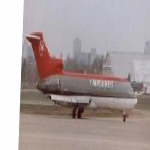

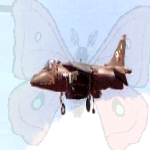

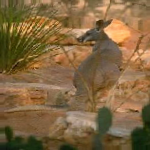

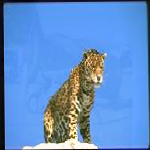

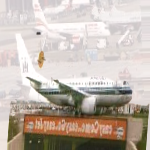

[[1.52732822e-06 9.99998473e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.89716265e-01 1.10283735e-01 0.00000000e+00]
 [0.00000000e+00 1.66502620e-02 0.00000000e+00 9.83349738e-01]
 [9.51367488e-01 4.86325123e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [5]:
sample_x, sample_y = next(train_generator)
for i in range(batch_size):
    display(image.array_to_img(sample_x[i]))
print(sample_y)


training steps:  81
validation steps:  34


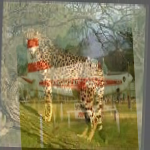

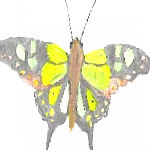

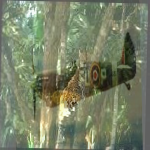

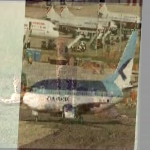

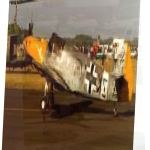

[[6.38811958e-01 3.61188042e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.07920610e-05 9.99939208e-01 0.00000000e+00]
 [6.20888152e-01 3.79111848e-01 0.00000000e+00 0.00000000e+00]
 [4.05289018e-01 5.94710982e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [6]:
print('training steps: ', train_generator.get_steps_per_epoch())
print('validation steps: ', validation_generator.samples // batch_size)
for item in train_generator:
    sample_x, sample_y = item
    for i in range(batch_size):
        display(image.array_to_img(sample_x[i]))
    print(sample_y)
    break

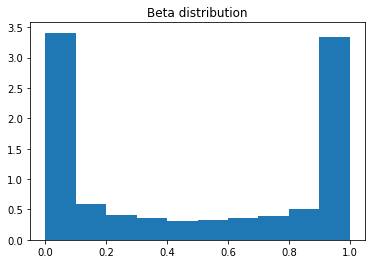

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
alpha = 0.2
array = np.random.beta(alpha, alpha, 5000)
h = sorted(array)  #sorted
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.hist(h,normed=True)
plt.title('Beta distribution')
plt.show()

In [8]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_height, img_width, 3))

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='sigmoid'))

conv_base.trainable = False
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 16,813,124
Trainable params: 2,098,436
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
train_generator.reset()
validation_generator.reset()
# Start the traning.
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.get_steps_per_epoch(),
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs)

Epoch 1/10
81/81 [==============================] - 8s 94ms/step - loss: 0.4465 - acc: 0.5870 - val_loss: 0.3029 - val_acc: 0.9059
Epoch 2/10
81/81 [==============================] - 6s 72ms/step - loss: 0.2846 - acc: 0.6475 - val_loss: 0.1830 - val_acc: 0.9574
Epoch 3/10
81/81 [==============================] - 6s 71ms/step - loss: 0.2145 - acc: 0.6556 - val_loss: 0.1231 - val_acc: 0.9853
Epoch 4/10
81/81 [==============================] - 6s 72ms/step - loss: 0.1853 - acc: 0.6414 - val_loss: 0.0964 - val_acc: 0.9794
Epoch 5/10
81/81 [==============================] - 6s 70ms/step - loss: 0.1707 - acc: 0.6438 - val_loss: 0.0783 - val_acc: 0.9882
Epoch 6/10
81/81 [==============================] - 6s 73ms/step - loss: 0.1553 - acc: 0.6432 - val_loss: 0.0676 - val_acc: 0.9897
Epoch 7/10
81/81 [==============================] - 6s 71ms/step - loss: 0.1694 - acc: 0.6333 - val_loss: 0.0631 - val_acc: 0.9926
Epoch 8/10
81/81 [==============================] - 6s 71ms/step - loss: 0.1466 - a